In [1]:
import time
import jax 
import jax.numpy as jnp
import numpy as np
from jax.scipy import optimize
from jax.experimental.optimizers import adam
import pandas as pd

# from jax.config import config
# config.update("jax_debug_nans", False)

In [2]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def tanh(X, w, b):
    return jax.nn.tanh(linear(X, w, b))
    

def V_hat(params):
    @jax.jit
    def f(X, x):
        X_tilde = jnp.concatenate([x.reshape(1, 1), jnp.dot(X, params['theta'])], axis=1)
        l1 = tanh(X_tilde, params['w0'], params['b0'])
        l2 = tanh(l1, params['w1'], params['b1'])
        l3 = tanh(l2, params['w2'], params['b2'])
        return jnp.squeeze(linear(l3, params['wf'], params['bf']))
    return f


@jax.jit
def opt_control(params, beta, X, i):
    x = X[0, i].reshape(1, 1)
    # If possible, solve for the optimal control analytically
    # v_hat = V_hat(params)
    # u_prime_inverse = lambda z: 1/z
    # grad = jax.grad(v_hat, argnums=(0, 1))(X, x)
#     inner_sum = jnp.clip(grad[0][0][i] + grad[1], 1e-10, None)
#     c_star = jnp.squeeze(jnp.clip(jnp.abs(u_prime_inverse(beta * (inner_sum))), 0, x))
    c_star = (1 - beta) * x
    # Otherwise, we have to resort to numerical optimization
#     f = lambda c: jnp.squeeze(- (u(c) + beta * v_hat(X, x - jnp.sum(c))))
#     c0 = jnp.ones(c_shape)
    
#     c_star = optimize.minimize(f, c0, method='BFGS', options={'line_search_maxiter': 10000, 'gtol': 1e-2}).x
    return c_star


@jax.jit
def future(params, beta, X, i):
    v_hat = V_hat(params)
    u = lambda c: jnp.log(c)
    c_star = opt_control(params, beta, X, i)
    
    x = X[0, i].reshape(1, 1)
    x_prime = x - jnp.sum(c_star)
    X_prime = X.at[0, i].set(jnp.squeeze(x_prime))
    return jnp.squeeze(u(c_star) + beta * v_hat(X_prime, x_prime))

  
@jax.jit
def epsilon(params, beta, X, i):
    X = X.reshape(1, -1)
    v_hat = V_hat(params)
    v = v_hat(X, X[0, i].reshape(1, 1))
    f = future(params, beta, X, i)
    
    return (v - f)**2

In [3]:
bs = 2**12
k = 1
m = 10
nn_shapes = jnp.array([m, 2*m, m])
beta = 0.95

X = jnp.exp(5 * jax.random.normal(jax.random.PRNGKey(123), shape=(bs, k))) - 1e3
N = jax.random.choice(jax.random.PRNGKey(10), jnp.arange(k), shape=(bs,))
theta0 = jax.random.normal(jax.random.PRNGKey(129), shape=(k, m))
w00 = jax.random.normal(jax.random.PRNGKey(6), shape=(m + 1, nn_shapes[0]))
w01 = jax.random.normal(jax.random.PRNGKey(7), shape=(nn_shapes[0], nn_shapes[1]))
w02 = jax.random.normal(jax.random.PRNGKey(8), shape=(nn_shapes[1], nn_shapes[2]))
w0f = jax.random.normal(jax.random.PRNGKey(9), shape=(nn_shapes[2], 1))
b00 = jax.random.normal(jax.random.PRNGKey(52), shape=(1, nn_shapes[0]))
b01 = jax.random.normal(jax.random.PRNGKey(51), shape=(1, nn_shapes[1]))
b02 = jax.random.normal(jax.random.PRNGKey(58), shape=(1, nn_shapes[2]))
b0f = jax.random.normal(jax.random.PRNGKey(48), shape=(1, 1))

params0 = {'theta': theta0, 'w0': w00, 'w1': w01, 'w2': w02, 'wf': w0f, 'b0': b00, 'b1': b01, 'b2': b02, 'bf':b0f}

In [4]:
j = 0
tol = 1e-10
err = jnp.inf
st = time.time()


@jax.jit
def condition(v):
    return e(get_params(v['opt_state']), v['X'], v['i']) > tol


@jax.jit
def update(v):
    params = get_params(v['opt_state'])
    grad = jax.grad(lambda params: e(params, v['X'], v['i']))(params)
    opt_state = opt_update(j, grad, v['opt_state'])
    return {'opt_state': opt_state, 'X': v['X'], 'j': v['j'] + 1, 'i': v['i']}


@jax.jit
def batch(i, X):
    X = X.reshape(1, -1)
    j = 0
    
    v = jax.lax.while_loop(condition, update, {'opt_state': opt_state0, 'X': X, 'j': j, 'i': i}) 
    fit_params = get_params(v['opt_state'])
    c_star = opt_control(fit_params, beta, X, i)
    x_prime = X[0, i] - c_star
    return jnp.array([c_star, x_prime]), fit_params


def training_loop(opt_update, opt_state, get_params, tol=1e-10, max_iter=1000):
    j = 0
    err = jnp.inf
    st = time.time()
    
    while err > tol and j < max_iter:
        params = get_params(opt_state)
        X = jnp.exp(jax.random.normal(jax.random.PRNGKey(np.random.randint(1, 100000)), shape=(bs, k)))
        N = jax.random.choice(jax.random.PRNGKey(np.random.randint(1, 100000)), jnp.arange(k), shape=(bs,))
        eb = lambda params: jnp.mean(jax.vmap(epsilon, in_axes=(None, None, 0, 0))(params, beta, X, N))
        grad = jax.grad(eb)(params)
        err = eb(params)
        opt_state = opt_update(j, grad, opt_state)
        j += 1
        if j % 100 == 0:
            print(f'Iteration: {j}\tMean Error: {err}\n')
            
    return opt_state

In [ ]:
opt_init, opt_update, get_params = adam(step_size=0.01)
opt_state = opt_init(params0)
opt_state = training_loop(opt_update, opt_state, get_params)

In [42]:
params = get_params(opt_state)

i = jax.random.choice(jax.random.PRNGKey(np.random.randint(1, 100000)), jnp.arange(1000), shape=(1,))
Xs = jnp.exp(jax.random.normal(jax.random.PRNGKey(np.random.randint(1, 100000)), shape=(1, 1000)))
x = Xs[0, i].reshape(1, 1)
X = x
xs = Xs[0, :]

v_estimated = V_hat(params)(X, x)
v_actual = (1 - beta) * jnp.log(x)

print(f'Estimated v(x): {v_estimated}\nActual v(x): {v_actual}')

Estimated v(x): -60.523380279541016
Actual v(x): [[0.00789384]]


In [52]:
opt_init, opt_update, get_params = adam(step_size=0.01)
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, get_params)

Iteration: 100	Mean Error: 0.12071365118026733

Iteration: 200	Mean Error: 0.05715564638376236

Iteration: 300	Mean Error: 0.03776395320892334

Iteration: 400	Mean Error: 0.06061437726020813

Iteration: 500	Mean Error: 0.016715966165065765

Iteration: 600	Mean Error: 0.028010327368974686

Iteration: 700	Mean Error: 0.021105002611875534

Iteration: 800	Mean Error: 0.014280089177191257

Iteration: 900	Mean Error: 0.011485960334539413

Iteration: 1000	Mean Error: 0.006579298060387373



<AxesSubplot:xlabel='X', ylabel='actual_v'>

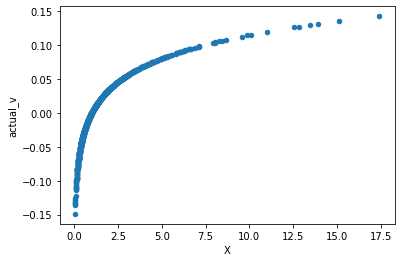

In [53]:
ves = jax.vmap(V_hat(params), in_axes=(None, 0))(X, xs)
vas = jax.vmap(lambda x: (1 - beta) * jnp.log(x))(Xs)
df = pd.DataFrame(jnp.concatenate((Xs.reshape(-1, 1), ves.reshape(-1, 1), vas.reshape(-1, 1)), axis=1))
df.columns = ['X', 'estimated_v', 'actual_v']
df.plot(x='X', y='actual_v', kind='scatter')

<AxesSubplot:xlabel='X', ylabel='estimated_v'>

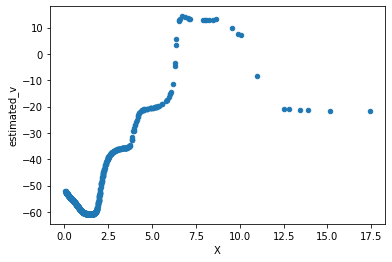

In [54]:
df.plot(x='X', y='estimated_v', kind='scatter')

In [51]:
((df['estimated_v'] - df['actual_v'])**2).mean()

2821.5115